In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
import numpy as np  # 导入 numpy
from scipy.stats import kruskal
import glob
import os
os.chdir('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/cytoscape')
font_files = font_manager.findSystemFonts(fontpaths='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/')
font_manager.fontManager.addfont('/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/Arial.ttf')
arial_font = font_manager.FontProperties(fname='Arial.ttf')
for file in font_files:
    font_manager.fontManager.addfont(file)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
RNA=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt',sep='\t')

In [2]:
loopnum=pd.DataFrame(index=['E-E','E-P','P-P','other'])
loopfrac=pd.DataFrame(index=['E-E','E-P','P-P','other'])
celllist=['GBM', 'NPC', 'iPSC', 'NHA']
for i in celllist:
	file = pd.read_csv(f'{i}/{i}_loop.bed',sep='\t')
	dupfile=file.loc[:,['loopid','E-E','E-P','P-P','other']].drop_duplicates()
	EE = dupfile['E-E'].sum()
	EP = dupfile['E-P'].sum()
	PP = dupfile['P-P'].sum()
	other = dupfile['other'].sum()
	loopnum[i] = [EE, EP, PP, other]
	# 除所有loop的数量
	loopid = dupfile['loopid'].nunique()
	print(loopid)
	loopfrac[i] = [EE / loopid, EP / loopid, PP / loopid, other / loopid]

# loopfrac = loopnum.apply(lambda x: x / x.sum(), axis=0)
print(loopfrac)
print(loopnum)


31487
27538
31747
43255
            GBM       NPC      iPSC       NHA
E-E    0.381554  0.230373  0.015246  0.048295
E-P    0.397910  0.287348  0.067880  0.143706
P-P    0.193921  0.175249  0.155920  0.209594
other  0.503986  0.627533  0.825558  0.758248
         GBM    NPC   iPSC    NHA
E-E    12014   6344    484   2089
E-P    12529   7913   2155   6216
P-P     6106   4826   4950   9066
other  15869  17281  26209  32798


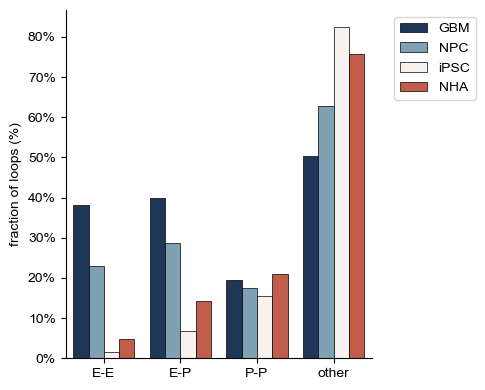

In [7]:
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LinearSegmentedColormap
bluered=["#16365F","#77A3BB","#F8F2ED","#D64F38"]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#1065ad' ,'white', '#bc020f' ])
mypalette = ['#a6cee3','#33a02c','#b2df8a','#1f78b4','#e31a1c','#fb9a99','#fdbf6f']

df_long = loopfrac.reset_index().melt(id_vars="index", var_name="Sample", value_name="Count")
df_long.rename(columns={"index": "Category"}, inplace=True)
fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(data=df_long, x="Category", y="Count", hue="Sample", palette=bluered, 
			ax=ax,    linewidth=0.5,      # 边线粗细（默认0，无边框）
    	edgecolor="black")   # 边线颜色（默认None）)

# 设置y轴为百分制
ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # 假设数据范围是 0~1（如 0.5 显示为 50%）
# 如果数据范围是 0~100，则用 PercentFormatter(100)

sns.despine()
ax.set_ylabel('fraction of loops (%)')  # 修改ylabel单位
ax.set_xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('loopfraction.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

In [9]:
NHA=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/cytoscape/NHA/NHA.EP',sep='\t',header=None)

In [12]:
NHA[10].value_counts()

--    32982
PP     9066
PE     3941
EP     3758
EE     2105
Name: 10, dtype: int64

In [12]:
RNA['Gene']=RNA['Gene'].astype(str).str.upper()

In [ ]:
RNAdf = pd.DataFrame(columns=['gene', 'cell', 'looptype'])

for cell in celllist:
    # 修正：使用cell变量而不是i
    file = pd.read_csv(f'{cell}/{cell}_loop.bed', sep='\t')
    
    # 转换数据格式
    long_df = file.melt(
        id_vars='gene',
        value_vars=['E-P', 'P-P', 'other'],
        var_name='looptype', 
        value_name='is_type'
    )
    result = long_df[long_df['is_type'] == 1].drop('is_type', axis=1)
    result['cell'] = cell
    
    RNAdf = pd.concat([RNAdf, result[['gene', 'cell', 'looptype']]], ignore_index=True)
RNAdf=RNAdf.drop_duplicates()


        gene cell looptype
0   PRKCZ-DT  GBM      E-P
1      PRKCZ  GBM      E-P
4  PRKCZ-AS1  GBM      E-P
7      MORN1  GBM      E-P
8       RER1  GBM      E-P


In [32]:
RNAlong=RNA.melt(
	id_vars='Gene',
	value_vars=['GBM','NPC','iPSC','NHA'],
	var_name='cell',
	value_name='expr'
)
RNAlong=RNAlong.rename(columns={'Gene':'gene'})

In [47]:
merged_df = pd.merge(
    RNAdf,
    RNAlong,
    on=['gene', 'cell'],  # 按两列合并
    how='left'            # 保留RNAdf的所有行，expr_df匹配不到的填NaN
)
# 检查结果
print(merged_df.head())

        gene cell looptype       expr
0   PRKCZ-DT  GBM      E-P        NaN
1      PRKCZ  GBM      E-P  21.947855
2  PRKCZ-AS1  GBM      E-P   2.420836
3      MORN1  GBM      E-P   6.365480
4       RER1  GBM      E-P  98.742888


In [48]:
merged_df['looptype'].value_counts()

P-P      52107
E-P      37459
other        4
Name: looptype, dtype: int64

In [36]:
merged_df.to_csv('RNA_loop.txt',sep='\t')

In [49]:

merged_df['logexpr']=np.log2(merged_df['expr']+1)

In [51]:
merged_df=merged_df.loc[merged_df['looptype']!='other',:]

In [52]:
merged_df.head()

,gene,cell,looptype,expr,logexpr
0,PRKCZ-DT,GBM,E-P,NaN,NaN
1,PRKCZ,GBM,E-P,21.947855,4.520287
2,PRKCZ-AS1,GBM,E-P,2.420836,1.774349
3,MORN1,GBM,E-P,6.365480,2.880779
4,RER1,GBM,E-P,98.742888,6.640142


In [68]:
genecounts=merged_df[['cell','looptype']].value_counts()

In [72]:
genecounts.index

MultiIndex([( 'NHA', 'P-P'),
            ( 'GBM', 'E-P'),
            ( 'GBM', 'P-P'),
            ('iPSC', 'P-P'),
            ( 'NPC', 'P-P'),
            ( 'NPC', 'E-P'),
            ( 'NHA', 'E-P'),
            ('iPSC', 'E-P')],
           names=['cell', 'looptype'])

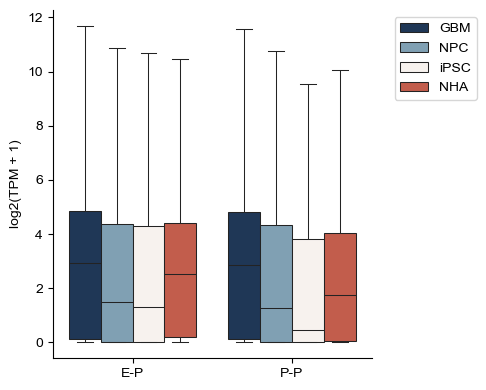

In [73]:
# from statannotations.Annotator import Annotator
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(data=merged_df, x="looptype", y="logexpr", hue="cell", palette=bluered, linewidth=0.75,  
			ax=ax,showfliers=False)   # 边线颜色（默认None）)

sns.despine()
ax.set_ylabel('log2(TPM + 1)')  # 修改ylabel单位
ax.set_xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('expr_loops.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

In [63]:
from scipy.stats import ttest_ind
from itertools import combinations
df=merged_df.copy()
df=df.dropna()
groups = ['GBM_E-P', 'GBM_P-P', 'NPC_E-P', 'NPC_P-P', 
          'iPSC_E-P', 'iPSC_P-P', 'NHA_E-P', 'NHA_P-P']
df['group'] = df['cell'] + '_' + df['looptype']  # 合并cell和looptype

# 计算所有两两t检验的p值
results = []
for (group1, group2) in combinations(groups, 2):
    data1 = df[df['group'] == group1]['logexpr']
    data2 = df[df['group'] == group2]['logexpr']
    t_stat, p_val = ttest_ind(data1, data2)
    results.append({
        'group1': group1,
        'group2': group2,
        'p_val': p_val
    })

# 转换为DataFrame并筛选显著结果 (p < 0.05)
results_df = pd.DataFrame(results)
significant_pairs = results_df[results_df['p_val'] < 0.05]
print("显著的两两比较：")
print(significant_pairs)

显著的两两比较：
      group1    group2          p_val
1    GBM_E-P   NPC_E-P   9.184878e-35
2    GBM_E-P   NPC_P-P   8.302511e-45
3    GBM_E-P  iPSC_E-P   4.612452e-19
4    GBM_E-P  iPSC_P-P  2.483280e-114
5    GBM_E-P   NHA_E-P   8.226109e-11
6    GBM_E-P   NHA_P-P   5.071074e-71
7    GBM_P-P   NPC_E-P   9.160340e-30
8    GBM_P-P   NPC_P-P   1.024819e-38
9    GBM_P-P  iPSC_E-P   6.442943e-17
10   GBM_P-P  iPSC_P-P  2.130825e-102
11   GBM_P-P   NHA_E-P   1.480531e-08
12   GBM_P-P   NHA_P-P   3.363035e-61
15   NPC_E-P  iPSC_P-P   2.225261e-21
16   NPC_E-P   NHA_E-P   4.729537e-09
17   NPC_E-P   NHA_P-P   7.782614e-03
19   NPC_P-P  iPSC_P-P   3.105074e-16
20   NPC_P-P   NHA_E-P   1.087586e-13
22  iPSC_E-P  iPSC_P-P   6.026070e-10
23  iPSC_E-P   NHA_E-P   2.180880e-06
25  iPSC_P-P   NHA_E-P   1.530879e-56
26  iPSC_P-P   NHA_P-P   2.312695e-18
27   NHA_E-P   NHA_P-P   1.771532e-22


In [62]:
data1

62180         NaN
62181         NaN
62182    6.316025
62183         NaN
62184    4.382667
           ...   
72019         NaN
72020    3.805292
72021    3.620977
72022    0.000000
72023    0.019109
Name: logexpr, Length: 9844, dtype: float64